In [1]:
import torch
import numpy as np

### Load Dataset

In [2]:
from torch.utils.data import DataLoader

In [3]:
data = np.load('./dataset/data64.npy')

In [4]:
data.shape

(3376, 3, 64, 64)

In [30]:
# normalize to [0, 1]
normalizer = lambda p: (p/255)
vfunc = np.vectorize(normalizer)
data_n = vfunc(data)

In [31]:
dataset = DataLoader(data_n,batch_size = 32,shuffle=True)

## VAE

In [8]:
import torch.nn as nn

In [66]:
class VAE(nn.Module):
    
    def __init__(self, latent_size, output_size, n_channels):
        super(VAE,self).__init__()
        params = {'kernel_size': 5, 'stride': 2, 'padding': 2}
        self.init_output = 3
        self.latent_size = latent_size
        self.output_size = output_size
        self.n_channels = n_channels
        self._build_encoder(params)
        self._build_decoder()
        
        
    
    def _build_encoder(self,params):
        self.elayer1 = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = self.init_output, **params),
            nn.BatchNorm2d(num_features = self.init_output),
            nn.LeakyReLU(0.2)
        )
        self.elayer2 = nn.Sequential(
            nn.Conv2d(in_channels = self.init_output, out_channels = self.init_output*2, **params),
            nn.BatchNorm2d(num_features = self.init_output*2),
            nn.LeakyReLU(0.2)
        )
        self.elayer3 = nn.Sequential(
            nn.Conv2d(in_channels = self.init_output*2, out_channels = self.init_output*4, **params),
            nn.BatchNorm2d(num_features = self.init_output*4),
            nn.LeakyReLU(0.2)
        )
        self.elayer4 = nn.Sequential(
            nn.Conv2d(in_channels = self.init_output*4, out_channels = self.init_output*8, **params),
            nn.BatchNorm2d(num_features = self.init_output*8),
            nn.LeakyReLU(0.2)
        )
        self.emean_output = nn.Sequential(
            nn.Linear(self.init_output*8*16,self.latent_size)
        )
        self.ecovariance_output = nn.Sequential(
            nn.Linear(self.init_output*8*16,self.latent_size),
            # force outputs to be positive
            nn.Softplus()
        )
        self.encoder_layers = [self.elayer1,self.elayer2,self.elayer3,self.elayer4]
    
    def _build_decoder(self):
        self.dlayer1 = nn.Sequential(
            nn.Linear(self.latent_size,self.latent_size*2),
            nn.ReLU()
        )
        self.dlayer2 = nn.Sequential(
            nn.Linear(self.latent_size*2,self.latent_size*4),
            nn.ReLU()
        )
        self.dmean_output = nn.Sequential(
            nn.Linear(self.latent_size*4,self.output_size**2 * self.n_channels)
        )
        self.dcovariance_output = nn.Sequential(
            nn.Linear(self.latent_size*4,self.output_size**2 * self.n_channels),
            # force outputs to be positive
            nn.Softplus()
        )
        self.decoder_layers = [self.dlayer1,self.dlayer2]
    
    
    def forward(self,X):
        for layer in self.encoder_layers:
            X = layer(X)
        X = X.view(-1,self.init_output*8*16)
        mu_ = self.emean_output(X)
        log_sigma_ = self.ecovariance_output(X)
        # reparaterization trick
        Z = mu_ + torch.exp(log_sigma_)*torch.randn(log_sigma_.shape).cuda()
        
        for layer in self.decoder_layers:
            Z = layer(Z)
        mu = self.dmean_output(Z)
        log_sigma = self.dcovariance_output(Z)
        out = mu + torch.exp(log_sigma)*torch.randn(log_sigma.shape).cuda()
        
        return mu_,log_sigma_,out.view(-1,self.n_channels,self.output_size,self.output_size)

In [52]:
vae = VAE(32,64,3).cuda()

In [65]:
optimizer = torch.optim.Adam(vae.parameters(),lr = 0.01, betas = (0.5,0.999))
n_epochs = 100
for e in range(n_epochs):
    losses = []
    KL_losses = []
    for i,batch in enumerate(dataset):
        vae.zero_grad()
        batch_ = batch.float().cuda()
        mu,log_sigma,out = vae(batch_)
        

        # losses
#         KL = torch.sum(-1/2 * (torch.pow(mu,2) + 2*torch.exp(log_sigma) - 1 - 2*log_sigma),1)
#         KL_losses.append(torch.mean(KL.data))
#         print(i,out,log_sigma_sq,KL.data)
        bce = -torch.sum(torch.sum(torch.sum( batch_ * torch.log(1e-10 + out) + (1-batch_) * torch.log(1e-10 + (1-out)), 1),1),1)
        
        loss = torch.mean(bce)
        losses.append(loss.data)

        loss.backward()
        optimizer.step()
#     print(losses)
    print('Epoch {e}: Loss: {loss} KL: {lol}'.format(e=e, loss = np.mean(losses), lol = 0))
    

Epoch 0: Loss: 87636.265625 KL: 0
Epoch 1: Loss: 86626.109375 KL: 0
Epoch 2: Loss: 86131.0 KL: 0
Epoch 3: Loss: 85827.8203125 KL: 0
Epoch 4: Loss: 85682.6796875 KL: 0
Epoch 5: Loss: 85530.9140625 KL: 0
Epoch 6: Loss: 85435.0625 KL: 0
Epoch 7: Loss: 85356.953125 KL: 0
Epoch 8: Loss: 85258.921875 KL: 0
Epoch 9: Loss: 85202.640625 KL: 0
Epoch 10: Loss: 85192.9921875 KL: 0
Epoch 11: Loss: 85159.484375 KL: 0
Epoch 12: Loss: 85112.0546875 KL: 0
Epoch 13: Loss: 85055.140625 KL: 0
Epoch 14: Loss: 85048.828125 KL: 0
Epoch 15: Loss: 85030.5 KL: 0
Epoch 16: Loss: 85015.3984375 KL: 0
Epoch 17: Loss: 85005.921875 KL: 0
Epoch 18: Loss: 84982.3515625 KL: 0
Epoch 19: Loss: 84990.0859375 KL: 0
Epoch 20: Loss: 84961.953125 KL: 0
Epoch 21: Loss: 84943.8046875 KL: 0
Epoch 22: Loss: 84950.953125 KL: 0


KeyboardInterrupt: 

In [63]:
import matplotlib.pyplot as plt
%matplotlib inline

In [71]:
out_ = out[10].cpu().data.numpy()
out_ = np.moveaxis(out_,0,2)

In [58]:
denormalizer = lambda p: p*255

In [59]:
vf = np.vectorize(denormalizer)

In [72]:
img = vf(out_)

In [73]:
img = np.clip(img,0,255).astype('uint8')

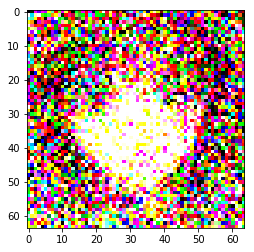

In [74]:
plt.imshow(img)

In [75]:
img

array([[[  0,   0,   9],
        [  0,  34,   0],
        [255,   0, 255],
        ...,
        [  0, 255, 175],
        [112,   0,  52],
        [168,   0,   0]],

       [[255, 255, 255],
        [  0, 226, 255],
        [255, 255, 174],
        ...,
        [ 46,  61,   0],
        [255,  95,  15],
        [  0,  24,   0]],

       [[117, 255, 255],
        [ 72, 255, 177],
        [255, 255,   0],
        ...,
        [ 15, 255, 124],
        [  0,  93,   0],
        [ 35,  59,   0]],

       ...,

       [[  0, 255,  85],
        [ 94,  86, 204],
        [255,   0,  85],
        ...,
        [255, 255, 255],
        [149,  42, 255],
        [206, 134,   0]],

       [[255, 255,   0],
        [208,   0, 255],
        [255, 255,   0],
        ...,
        [255,   0, 255],
        [255, 255, 255],
        [255, 255,   0]],

       [[255, 255,   0],
        [185, 255,  52],
        [185, 255,   0],
        ...,
        [255, 167,   0],
        [255, 255, 254],
        [  0, 255,  95]]